Start with a simple constant model:

Hierarchical across country, time

No covariates

Just model p(disaster | country, time), where country and time are fixed effects

Model each disaster independently

We need to choose between three possible distributions for the observed data:

- Poisson
- Negative Binomial
- Zero-Inflated Poisson

Do a test of each of these and report which one is the most appropriate

In [1]:
import sys
sys.path.append("..")

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
from os.path import exists

import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az

config = {
    'figure.figsize':(14,4),
    'figure.constrained_layout.use':True,
    'figure.facecolor':'w',
    'axes.grid':True,
    'grid.linewidth':0.5,
    'grid.linestyle':'--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

In [2]:
from laos_gggi.emdat_processing import process_emdat
from laos_gggi.plotting import plot_descriptive, _plot_single_kde, subplots_function, subplots_function_regions
from laos_gggi.const_vars import EM_DAT_COL_DICT, DISASTERS_FOUND, INTENSITY_COLS, EM_DAT_COL_DICT, PROB_COLS, REGIONS
from laos_gggi.summary_stats import descriptive_stats_function

# Data

## Climate Data - need to replace with functions, for sake of time just re-using code for today

In [3]:
CO2_URL = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_annmean_mlo.csv"
CO2_FILENAME = "noaa_co2.csv"
OCEAN_HEAT_URL = "https://www.ncei.noaa.gov/data/oceans/woa/DATA_ANALYSIS/3M_HEAT_CONTENT/DATA/basin/3month/ohc_levitus_climdash_seasonal.csv"
# https://www.ncei.noaa.gov/access/global-ocean-heat-content/basin_heat_data_monthly.html
OCEAN_HEAT_FILENAME = "ncei_global_ocean_heat.csv"

In [4]:
def process_ocean_heat(data_path="../data"):
    if not exists(data_path):
        os.makedirs(data_path)

    if not os.path.isfile(os.path.join(data_path, OCEAN_HEAT_FILENAME)):
        df_ocean = pd.read_csv(OCEAN_HEAT_URL, header=0, names=['Date','Temp'])
        df_ocean.Date = pd.to_datetime(df_ocean.Date, format='%Y-%m')
        df_ocean.set_index("Date", inplace=True)
        df_ocean.to_csv(os.path.join(data_path, OCEAN_HEAT_FILENAME))

    else:
        df_ocean = pd.read_csv(
            os.path.join(data_path, OCEAN_HEAT_FILENAME),
            index_col=["Date"],
            parse_dates=True,
        )

    return df_ocean

In [5]:
def process_co2(data_path="../data"):
    if not exists(data_path):
        os.makedirs(data_path)

    if not os.path.isfile(os.path.join(data_path, CO2_FILENAME)):
        df_co2 = pd.read_csv(CO2_URL, skiprows=43)
        df_co2['month'] = 1
        df_co2['day'] = 1
        df_co2['Date'] = pd.to_datetime(df_co2[['year', 'month', 'day']])
        df_co2.set_index("Date", inplace=True)
        df_co2.rename(columns={"mean": "co2"}, inplace=True)
        df_co2 = df_co2[["co2"]]
        df_co2.to_csv(os.path.join(data_path, CO2_FILENAME))

    else:
        df_co2 = pd.read_csv(
            os.path.join(data_path, CO2_FILENAME), index_col=["Date"], parse_dates=True
        )

    return df_co2

In [6]:
df_ocean = process_ocean_heat()
df_co2 = process_co2()

In [7]:
df_ocean = df_ocean.resample('YE').mean()
df_ocean.reset_index(inplace=True)
df_ocean['Date'] = df_ocean['Date'] - pd.offsets.YearBegin()
df_ocean.set_index("Date", inplace=True)
df_ocean = df_ocean.iloc[1:-1] #Dropping first and last column with incomplete data
df_ocean = df_ocean + 152 #add back in baseline that was subtracted from the data

In [8]:
df_ocean = 100*(df_ocean - df_ocean.mean())/df_ocean.std()
df_co2 = 100*(df_co2 - df_co2.mean())/df_co2.std()

In [9]:
df_clim = pd.DataFrame.merge(df_ocean,df_co2,how='inner',left_index=True, right_index=True).dropna()

## EM-DAT data

In [10]:
data = process_emdat()

df_prob_filtered_adjusted = data["df_prob_filtered_adjusted"]
df_inten_filtered_adjusted = data["df_inten_filtered_adjusted"]

In [11]:
df_prob_filtered_adjusted['dis_count'] = df_prob_filtered_adjusted.iloc[:, 2:].sum(axis=1)

In [12]:
df = df_prob_filtered_adjusted.reset_index()

In [13]:
years = df["Start_Year"].drop_duplicates().sort_values().to_list()[:-1] #current year is not complete
countries = df["ISO"].drop_duplicates().sort_values().to_list()

In [14]:
df_blank = pd.DataFrame(columns=["dis_count"], index=pd.MultiIndex.from_product([years, countries], names=['Start_Year', 'ISO']))

In [15]:
df_counts = df_prob_filtered_adjusted[["dis_count"]].sort_values(["Start_Year","ISO"]).reset_index().set_index(["Start_Year","ISO"])

In [16]:
df_filled = df_blank.combine_first(df_counts).fillna(0)


/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_31597/1264795223.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filled = df_blank.combine_first(df_counts).fillna(0)


In [17]:
df_counts = df_filled.reset_index().pivot(index='Start_Year', columns='ISO').iloc[:-1,:]

In [18]:
df = df_filled.reset_index()

## Merge

In [ ]:
df_clim = df_clim.reset_index()
df_clim['Start_Year'] = df_clim['Date'].dt.year.astype('str')
df_clim['Start_Year'] = df_clim['Start_Year'].astype('int64')
df = pd.merge(df, df_clim[['Start_Year','Temp','co2']], on='Start_Year', how='left')
df = df.dropna()

In [69]:
df['ISO'] = df['ISO'].astype(CategoricalDtype())
df['Start_Year'] = df['Start_Year'].astype(CategoricalDtype())

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_31597/745270433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ISO'] = df['ISO'].astype(CategoricalDtype())
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_31597/745270433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Start_Year'] = df['Start_Year'].astype(CategoricalDtype())


In [70]:
df.info()

,Start_Year,ISO,dis_count,Temp,co2
0,1971,AFG,0.0,-101.761471,-105.155662
1,1971,AGO,0.0,-101.761471,-105.155662
2,1971,AIA,0.0,-101.761471,-105.155662
3,1971,ALB,0.0,-101.761471,-105.155662
4,1971,ANT,0.0,-101.761471,-105.155662
...,...,...,...,...,...
10648,2023,YMN,0.0,229.977605,197.350426
10649,2023,YUG,0.0,229.977605,197.350426
10650,2023,ZAF,3.0,229.977605,197.350426
10651,2023,ZMB,2.0,229.977605,197.350426


# Models

## Poisson

In [215]:
POST_PRED_KWARGS = dict(return_inferencedata=True, extend_inferencedata=True)

In [232]:
COORDS = {'Country_vals':df['ISO'].cat.categories.values, 
          #'Year_vals':df['Start_Year'].cat.categories.values,
          "obs_idx": df.index}

with pm.Model(coords=COORDS) as disaster_model:

    b0 = pm.Normal("Intercept", mu=0, sigma=1)
    b1 = pm.Normal("Country", mu=0, sigma=1, dims="Country_vals")
   # b2 = pm.Normal("Year", mu=0, sigma=1, dims="Year_vals")
    b3 = pm.Normal("Ocean", mu=0, sigma=1)
    b4 = pm.Normal("CO2", mu=0, sigma=1)

    country_data = pm.Data('country_data', df['ISO'].cat.codes.to_numpy(), dims="obs_idx")
#    year_data = pm.Data('year_data', df['Start_Year'].cat.codes.to_numpy(), dims="obs_idx")

    theta = (b0 + b1[country_data] 
        #+ b2[year_data]
        + b3*df['Temp']/100 + b4*df['co2']/100)

    # ## Define Poisson likelihood
    y_hat = pm.Poisson("y_hat", mu=pm.math.exp(theta), observed=df['dis_count'].values)
    
    dis_idata = pm.sample()
    dis_idata = pm.sample_posterior_predictive(dis_idata, 
                                                predictions=True, 
                                                **POST_PRED_KWARGS).assign_coords({"obs_idx":df.index})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Country, Ocean, CO2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_hat]


Output()

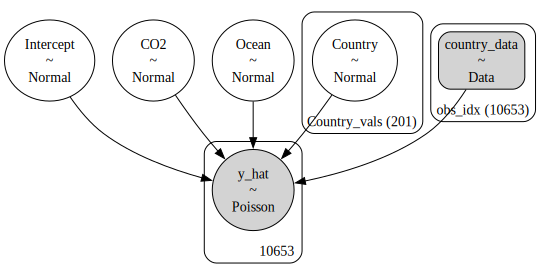

In [233]:
pm.model_to_graphviz(disaster_model)

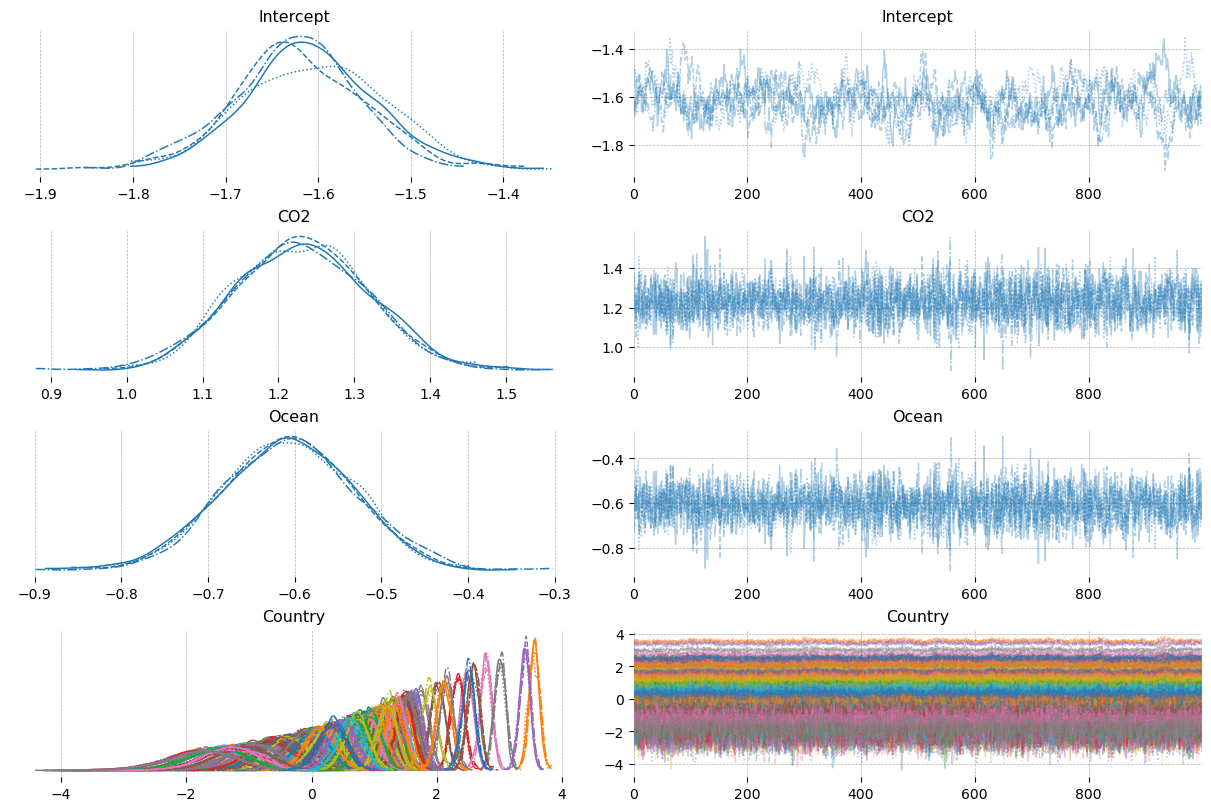

In [234]:
az.plot_trace(dis_idata, var_names=['Intercept','CO2','Ocean','Country']);

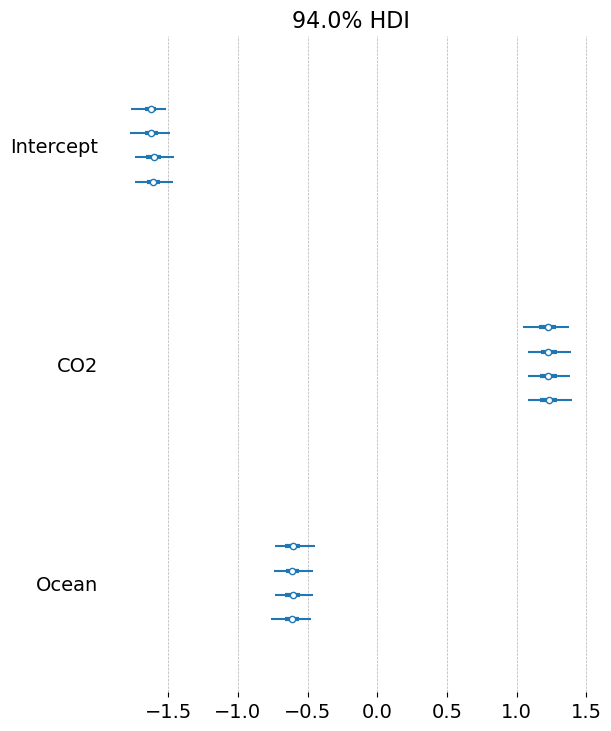

In [235]:
az.plot_forest(dis_idata, var_names=['Intercept','CO2','Ocean']);

In [236]:
predictions = np.mean(dis_idata.predictions['y_hat'], axis=(0, 1))

In [237]:
hdi_mean = az.hdi(dis_idata.predictions.y_hat)

hdi = pd.DataFrame(hdi_mean['y_hat']).rename(columns={0:'low',1:'high'})

df['high'] = hdi['high']
df['low'] = hdi['low']

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_31597/2779712477.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['high'] = hdi['high']
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_31597/2779712477.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['low'] = hdi['low']


In [238]:
hdi_mean_50 = az.hdi(dis_idata.predictions.y_hat, hdi_prob=.5)

hdi_50 = pd.DataFrame(hdi_mean_50['y_hat']).rename(columns={0:'low',1:'high'})

df['high_50'] = hdi_50['high']
df['low_50'] = hdi_50['low']

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_31597/3660276139.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['high_50'] = hdi_50['high']
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_31597/3660276139.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['low_50'] = hdi_50['low']


In [239]:
df

,Start_Year,ISO,dis_count,Temp,co2,preds,error,high,low,high_50,low_50
0,1971,AFG,0.0,-101.761471,-105.155662,0.48050,0.230880,2.0,0.0,0.0,0.0
1,1971,AGO,0.0,-101.761471,-105.155662,0.29350,0.086142,1.0,0.0,0.0,0.0
2,1971,AIA,0.0,-101.761471,-105.155662,0.01950,0.000380,0.0,0.0,0.0,0.0
3,1971,ALB,0.0,-101.761471,-105.155662,0.11050,0.012210,1.0,0.0,0.0,0.0
4,1971,ANT,0.0,-101.761471,-105.155662,0.02175,0.000473,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
10648,2023,YMN,0.0,229.977605,197.350426,0.15875,0.025202,1.0,0.0,0.0,0.0
10649,2023,YUG,0.0,229.977605,197.350426,0.10150,0.010302,1.0,0.0,0.0,0.0
10650,2023,ZAF,3.0,229.977605,197.350426,1.90075,1.208351,4.0,0.0,2.0,1.0
10651,2023,ZMB,2.0,229.977605,197.350426,1.03650,0.928332,3.0,0.0,1.0,0.0


In [240]:
df['preds'] = predictions

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_31597/2187056496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = predictions


In [241]:
df['error'] = (df['dis_count'] - df['preds'])**2

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_31597/1652729652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['error'] = (df['dis_count'] - df['preds'])**2


<Axes: xlabel='dis_count', ylabel='preds'>

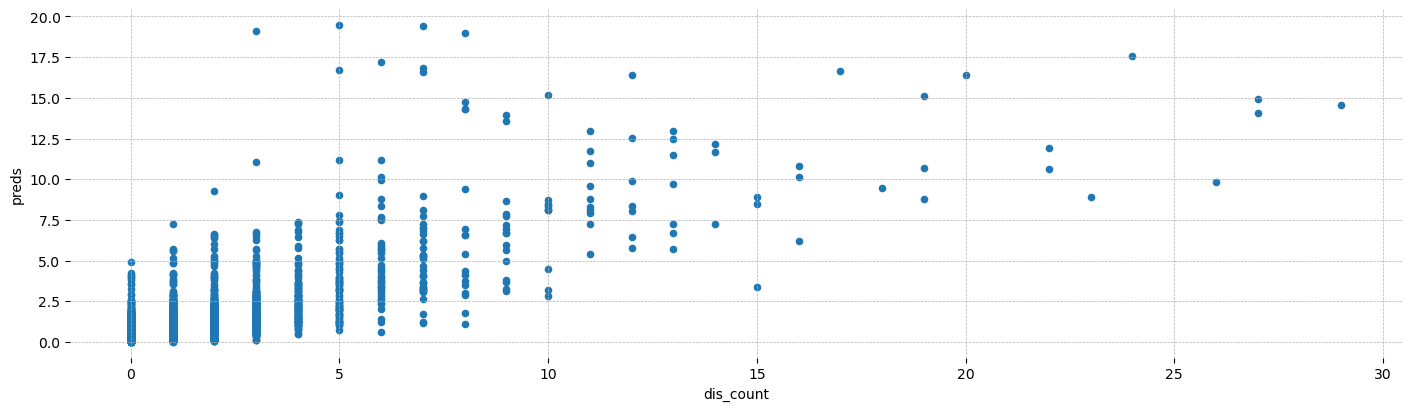

In [242]:
df.plot.scatter(x='dis_count',y='preds')

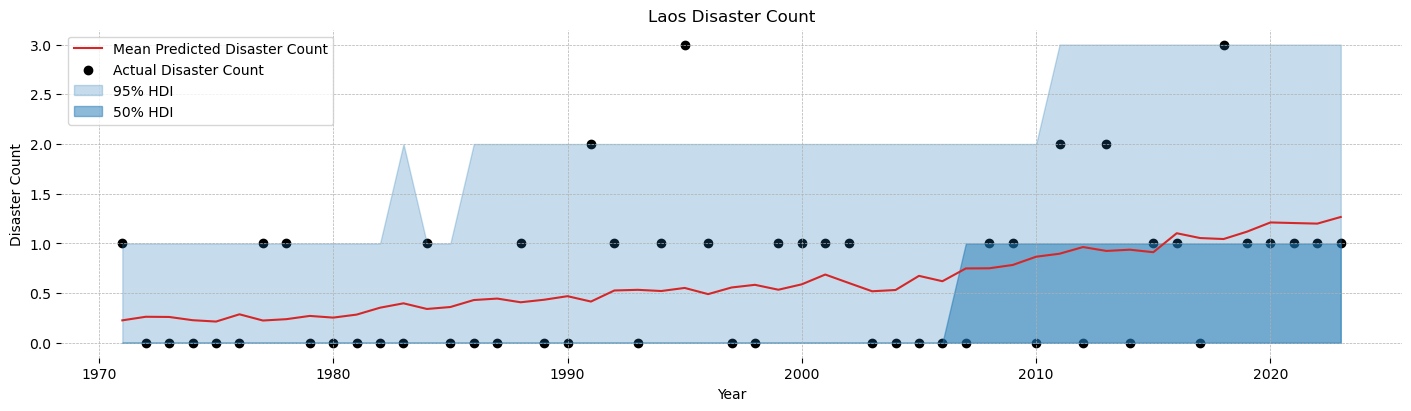

In [243]:
data = df.query("ISO == 'LAO'").set_index(['Start_Year'])[['dis_count','preds','high','low','high_50','low_50']].groupby('Start_Year',observed=True).mean().reset_index()

fig, ax = plt.subplots()
ax.plot(data.Start_Year, data.preds, zorder=1000, color='tab:red', label='Mean Predicted Disaster Count')
ax.scatter(data.Start_Year, data.dis_count, color='k', label='Actual Disaster Count')
ax.fill_between(data.Start_Year, data.high, data.low, alpha=0.25, color='tab:blue', label='95% HDI')
ax.fill_between(data.Start_Year, data.high_50, data.low_50, alpha=0.5, color='tab:blue', label='50% HDI')
ax.legend(loc='upper left')

plt.title("Laos Disaster Count")

plt.xlabel("Year")
plt.ylabel("Disaster Count")

plt.show()

Examples from other countries in the region of various sizes; Cambodia, Thailand, and Indonesia:

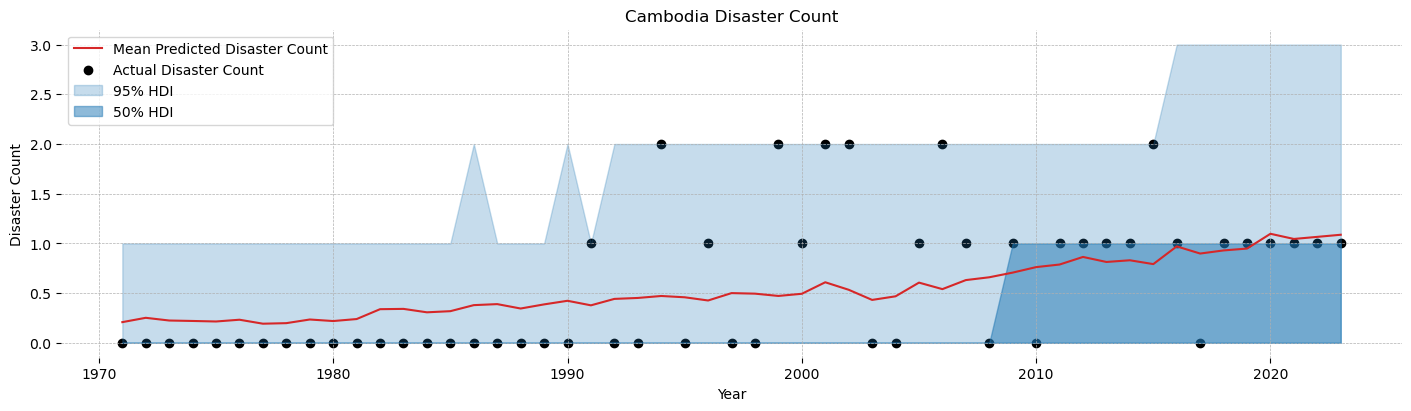

In [244]:
data = df.query("ISO == 'KHM'").set_index(['Start_Year'])[['dis_count','preds','high','low','high_50','low_50']].groupby('Start_Year',observed=True).mean().reset_index()

fig, ax = plt.subplots()
ax.plot(data.Start_Year, data.preds, zorder=1000, color='tab:red', label='Mean Predicted Disaster Count')
ax.scatter(data.Start_Year, data.dis_count, color='k', label='Actual Disaster Count')
ax.fill_between(data.Start_Year, data.high, data.low, alpha=0.25, color='tab:blue', label='95% HDI')
ax.fill_between(data.Start_Year, data.high_50, data.low_50, alpha=0.5, color='tab:blue', label='50% HDI')
ax.legend(loc='upper left')

plt.title("Cambodia Disaster Count")

plt.xlabel("Year")
plt.ylabel("Disaster Count")

plt.show()

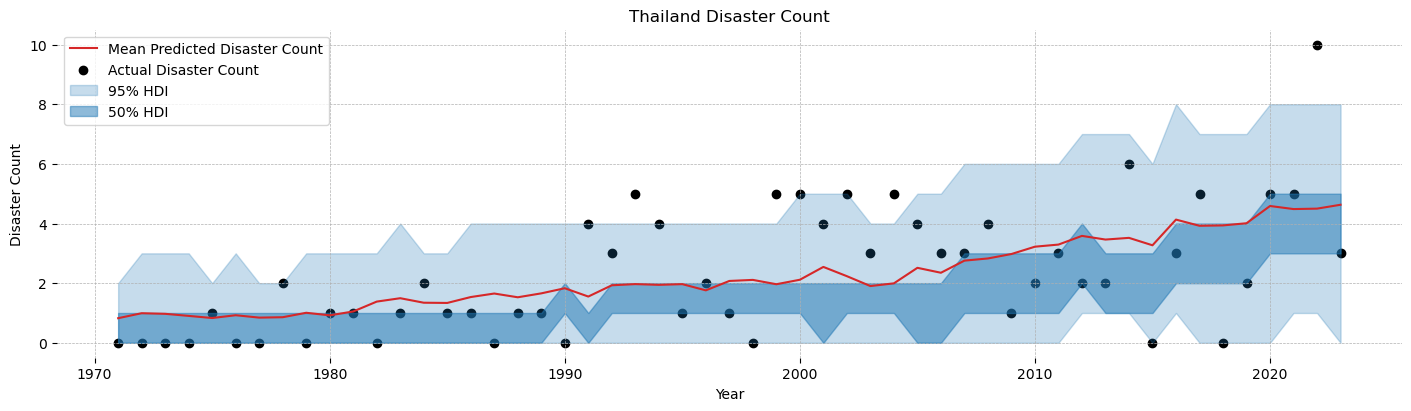

In [245]:
data = df.query("ISO == 'THA'").set_index(['Start_Year'])[['dis_count','preds','high','low','high_50','low_50']].groupby('Start_Year',observed=True).mean().reset_index()

fig, ax = plt.subplots()
ax.plot(data.Start_Year, data.preds, zorder=1000, color='tab:red', label='Mean Predicted Disaster Count')
ax.scatter(data.Start_Year, data.dis_count, color='k', label='Actual Disaster Count')
ax.fill_between(data.Start_Year, data.high, data.low, alpha=0.25, color='tab:blue', label='95% HDI')
ax.fill_between(data.Start_Year, data.high_50, data.low_50, alpha=0.5, color='tab:blue', label='50% HDI')
ax.legend(loc='upper left')

plt.title("Thailand Disaster Count")

plt.xlabel("Year")
plt.ylabel("Disaster Count")

plt.show()

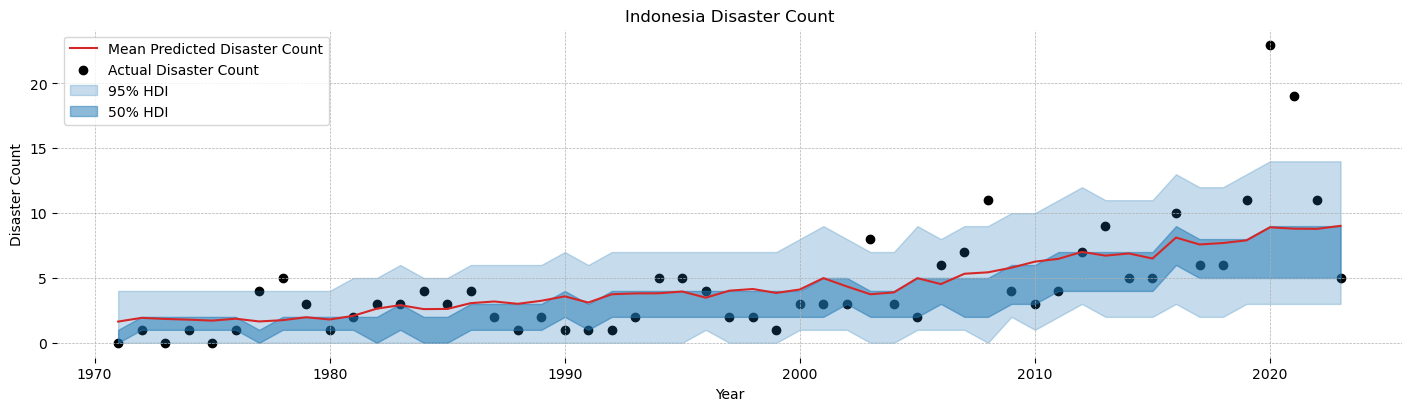

In [246]:
data = df.query("ISO == 'IDN'").set_index(['Start_Year'])[['dis_count','preds','high','low','high_50','low_50']].groupby('Start_Year',observed=True).mean().reset_index()

fig, ax = plt.subplots()
ax.plot(data.Start_Year, data.preds, zorder=1000, color='tab:red', label='Mean Predicted Disaster Count')
ax.scatter(data.Start_Year, data.dis_count, color='k', label='Actual Disaster Count')
ax.fill_between(data.Start_Year, data.high, data.low, alpha=0.25, color='tab:blue', label='95% HDI')
ax.fill_between(data.Start_Year, data.high_50, data.low_50, alpha=0.5, color='tab:blue', label='50% HDI')
ax.legend(loc='upper left')

plt.title("Indonesia Disaster Count")

plt.xlabel("Year")
plt.ylabel("Disaster Count")

plt.show()